In [17]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [18]:
n = 128
x_1 = np.linspace(-1, 1, 2*n+1)
y_1 = np.linspace(1, 0, n+1)
Y_1, X_1 = np.meshgrid(y_1, x_1)
x_2 = np.linspace(-1, 0, n+1)
y_2 = np.linspace(-1/n, -1, n)
Y_2, X_2 = np.meshgrid(y_2, x_2)

x = np.vstack((X_1.flatten(order='F')[:, None], X_2.flatten(order='F')[:, None]))
y = np.vstack((Y_1.flatten(order='F')[:, None], Y_2.flatten(order='F')[:, None]))

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [19]:
X_v_test = np.hstack((x, y))
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
theta = np.where(theta < 0, theta + 2*np.pi, theta)
sd = r**(2/3) * np.sin(2*theta/3)
R = 1/2
etad = np.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
etad = np.where(r < R/2, 1, etad)

lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

# Training Data

In [20]:
def trainingdata(N_v,N_f):
    
    edge1_x = np.hstack((np.linspace(-1, 1, 2*n+1)[:, None], np.linspace(1, 1, 2*n+1)[:, None]))
    edge2_x = np.hstack((np.linspace(1, 1, n+1)[:, None], np.linspace(1, 0, n+1)[:, None]))
    edge3_x = np.hstack((np.linspace(1, 0, n+1)[:, None], np.linspace(0, 0, n+1)[:, None]))
    edge4_x = np.hstack((np.linspace(0, 0, n+1)[:, None], np.linspace(0, -1, n+1)[:, None]))
    edge5_x = np.hstack((np.linspace(0, -1, n+1)[:, None], np.linspace(-1, -1, n+1)[:, None]))
    edge6_x = np.hstack((np.linspace(-1, -1, 2*n+1)[:, None], np.linspace(-1, 1, 2*n+1)[:, None]))

    all_X_v_train = np.vstack([edge1_x, edge2_x, edge3_x, edge4_x, edge5_x, edge6_x])

    # choose random N_v points for training
    all_X_v_train_r = np.sqrt(all_X_v_train[:, 0]**2 + all_X_v_train[:, 1]**2)
    probability = np.where(all_X_v_train_r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False, p=probability)
    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    probability = np.where(r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability.T[0])
    X_f = X_v_test[idx[0:N_f], :]

    X_f_train = np.vstack((X_f, X_v_train))  # append training points to collocation points

    return X_f_train, X_v_train

# SEPINN

Creating sequential layers using the class
tf.Module

In [21]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers1,layers2):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears1 = nn.ModuleList([nn.Linear(layers1[i], layers1[i+1]) for i in range(len(layers1)-1)])
        self.linears2 = nn.ModuleList([nn.Linear(layers2[i], layers2[i+1]) for i in range(len(layers2)-1)])
        
        # Parameter
        #self.lambdah = torch.nn.Parameter(0.8*torch.ones(1).to(device),requires_grad=True)
        self.lambdah1 = torch.autograd.Variable(torch.ones(1).to(device),requires_grad=True)
        self.lambdah2 = torch.autograd.Variable(torch.ones(1).to(device),requires_grad=True)
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers1)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears1[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears1[i].bias.data)
            
        for i in range(len(layers2)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears2[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears2[i].bias.data)    
            

    def forward1(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers1)-2):
            
            z = self.linears1[i](a)
                        
            a = self.activation(z)
            
        a = self.linears1[-1](a)
        
        return a
    
    def forward2(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers2)-2):
            
            z = self.linears2[i](a)
                        
            a = self.activation(z)
            
        a = self.linears2[-1](a)
        
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_v = self.loss_function(self.forward1(x), y)
                
        return loss_v
    
    def loss_BC2(self,x,y):
                
        loss_v = self.loss_function(self.forward2(x), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f,sigma):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv1 = self.forward1(g)
        vv2 = self.forward2(g)
                
        v_x1 = autograd.grad(vv1,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_11 = v_x1[:,[0]]
        v_x_21 = v_x1[:,[1]]
        v_xx1 = autograd.grad(v_x_11,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy1 = autograd.grad(v_x_21,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_11 = v_xx1[:,[0]]
        v_xx_21 = v_yy1[:,[1]]
        
        v_x2 = autograd.grad(vv2,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_12 = v_x2[:,[0]]
        v_x_22 = v_x2[:,[1]]
        v_xx2 = autograd.grad(v_x_12,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy2 = autograd.grad(v_x_22,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_12 = v_xx2[:,[0]]
        v_xx_22 = v_yy2[:,[1]]
                        
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        eta = torch.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        p = r**(2/3) * np.sin(2*theta/3) * eta
        
        deltap = torch.where(r < R,
                          -4 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (8 * r - 3) ** 3 + 3.3125) * np.sin(
                              2 * theta / 3) / (9 * r ** (4 / 3)) + (2 / 3 * (
                                  -7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (1 / 3) + r ** (
                                                                             2 / 3) * (
                                                                             -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                                             8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) + r * (-2 / 9 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (4 / 3) + 4 / 3 * (
                                                            -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                            8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) / r ** (1 / 3) + r ** (2 / 3) * (
                                                            1920.0 * r - 240.0 * (8 * r - 3) ** 3 - 720.0) * np.sin(
                              2 * theta / 3))) / r, 0)
        deltap = torch.where(r < R / 2, 0, deltap)
        
        rayleigh1 = torch.mean((-v_xx_11 - v_xx_21)*(vv1+self.lambdah1 * p))/torch.mean((vv1 + self.lambdah1*p)**2)
        rayleigh2 = torch.mean((-v_xx_12 - v_xx_22)*(vv2+self.lambdah2 * p))/torch.mean((vv2 + self.lambdah2*p)**2)
        rayleigh = [rayleigh1,rayleigh2]
        
        F1 = v_xx_11 + v_xx_21 + rayleigh1 * (vv1 + self.lambdah1 * p) + self.lambdah1 * deltap
        F2 = v_xx_12 + v_xx_22 + rayleigh2 * (vv2 + self.lambdah2 * p) + self.lambdah2 * deltap
        
        loss_norm = torch.abs(3*torch.mean((vv1 + self.lambdah1*p)**2)-1)+torch.abs(3*torch.mean((vv2 + self.lambdah2*p)**2)-1)
        
        loss_f = self.loss_function(F1, f_hat) + self.loss_function(F2, f_hat) + 100*loss_norm + 135*torch.abs(torch.mean((vv1 + self.lambdah1*p)*(vv2 + self.lambdah2*p))) + 0.02*rayleigh1**2 + 0.01*rayleigh2**2
        
        return loss_f, rayleigh
    
    def loss_PDE_new(self, x_to_train_f,sigma, rayleigh):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv1 = self.forward1(g)
        vv2 = self.forward2(g)
                
        v_x1 = autograd.grad(vv1,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_11 = v_x1[:,[0]]
        v_x_21 = v_x1[:,[1]]
        v_xx1 = autograd.grad(v_x_11,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy1 = autograd.grad(v_x_21,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_11 = v_xx1[:,[0]]
        v_xx_21 = v_yy1[:,[1]]
        
        v_x2 = autograd.grad(vv2,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_x_12 = v_x2[:,[0]]
        v_x_22 = v_x2[:,[1]]
        v_xx2 = autograd.grad(v_x_12,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy2 = autograd.grad(v_x_22,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_12 = v_xx2[:,[0]]
        v_xx_22 = v_yy2[:,[1]]
                        
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        eta = torch.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        p = r**(2/3) * np.sin(2*theta/3) * eta
        
        deltap = torch.where(r < R,
                          -4 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (8 * r - 3) ** 3 + 3.3125) * np.sin(
                              2 * theta / 3) / (9 * r ** (4 / 3)) + (2 / 3 * (
                                  -7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (1 / 3) + r ** (
                                                                             2 / 3) * (
                                                                             -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                                             8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) + r * (-2 / 9 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (4 / 3) + 4 / 3 * (
                                                            -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                            8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) / r ** (1 / 3) + r ** (2 / 3) * (
                                                            1920.0 * r - 240.0 * (8 * r - 3) ** 3 - 720.0) * np.sin(
                              2 * theta / 3))) / r, 0)
        deltap = torch.where(r < R / 2, 0, deltap)

        rayleigh1 = rayleigh[0]
        rayleigh2 = rayleigh[1]
        F1 = v_xx_11 + v_xx_21 + rayleigh1 * (vv1 + self.lambdah1 * p) + self.lambdah1 * deltap
        F2 = v_xx_12 + v_xx_22 + rayleigh2 * (vv2 + self.lambdah2 * p) + self.lambdah2 * deltap
        
        loss_norm = torch.abs(3*torch.mean((vv1 + self.lambdah1*p)**2)-1)+torch.abs(3*torch.mean((vv2 + self.lambdah2*p)**2)-1)
        
        loss_f = self.loss_function(F1, f_hat) + self.loss_function(F2, f_hat) + 100*loss_norm + 135*torch.abs(torch.mean((vv1 + self.lambdah1*p)*(vv2 + self.lambdah2*p))) + 0.02*rayleigh1**2 + 0.01*rayleigh2**2
        
        return loss_f
    
    def loss(self,x,y,x_to_train_f,sigma):

        loss_v1 = self.loss_BC1(x,y)
        loss_v2 = self.loss_BC2(x,y)
        loss_f, rayleigh = self.loss_PDE(x_to_train_f,sigma)

        loss = sigma * loss_v1 + sigma * loss_v2 + loss_f

        return loss
    
    def loss_new(self,x,y,x_to_train_f,sigma, rayleigh):

        loss_v1 = self.loss_BC1(x,y)
        loss_v2 = self.loss_BC2(x,y)
        loss_f = self.loss_PDE_new(x_to_train_f,sigma, rayleigh)

        loss = sigma * loss_v1 + sigma * loss_v2 + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss_new(X_v_train, v_train, X_f_train, sigma, rayleigh)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred_1 = self.forward1(X_v_test_tensor)
        u_pred_1 = v_pred_1.cpu().detach().numpy() + self.lambdah1.cpu().detach().numpy() * sd * etad
        
        v_pred_2 = self.forward2(X_v_test_tensor)
        u_pred_2 = v_pred_2.cpu().detach().numpy() + self.lambdah2.cpu().detach().numpy() * sd * etad
        
        _, rayleigh = self.loss_PDE(X_f_train,sigma)
        
        print('lambdah1:%.6f'%(self.lambdah1))
        print('lambdah2:%.6f'%(self.lambdah2))
        
        for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
            for j in range(n+1, 2*n+1):
                u_pred_1 = np.insert(u_pred_1, i*(2*n+1)+j, 0)
        u_pred_1 = np.reshape(u_pred_1, (2*n+1, 2*n+1), order='F')
        
        for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
            for j in range(n+1, 2*n+1):
                u_pred_2 = np.insert(u_pred_2, i*(2*n+1)+j, 0)
        u_pred_2 = np.reshape(u_pred_2, (2*n+1, 2*n+1), order='F')
        
        return rayleigh, u_pred_1, u_pred_2

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)
Training time: 1395.85
lambdah1:0

C:\Users\HP\AppData\Local\Temp/ipykernel_13612/1165011271.py:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred_1, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_13612/1165011271.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred_2, cmap='jet')


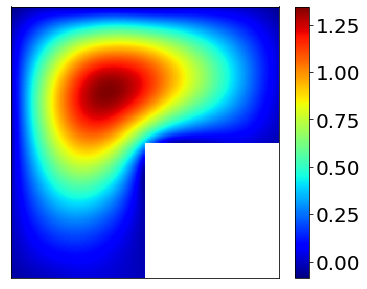

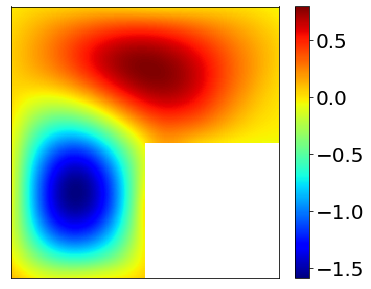

In [22]:
N_v = 800 
N_f = 10000 

X_f_train_np_array, X_v_train_np_array = trainingdata(N_v,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.zeros(X_v_train.shape[0],1).to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)


layers1 = np.array([2,10,10,10,10,10,10,1])
layers2 = np.array([2,10,10,10,10,10,10,1])
       
PINN = Sequentialmodel(layers1, layers2)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)
params = list(PINN.parameters())
sigma = 50
error_vec = 1
start_time = time.time()

while sigma < 600:
    optimizer = optim.Adam(PINN.parameters(), lr=2e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizerl = optim.Adam([PINN.lambdah1], lr=2e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer2 = optim.Adam([PINN.lambdah2], lr=2e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    max_iter = 2500
    if sigma == 569.53125:
        max_iter = 813
    for i in range(max_iter):
        loss = PINN.loss(X_v_train, v_train, X_f_train, sigma)
        optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
        optimizerl.zero_grad()     # zeroes the gradient buffers of all parameters
        optimizer2.zero_grad()     # zeroes the gradient buffers of all parameters
        loss.backward()       #backprop
        optimizer.step()
        optimizerl.step()
        optimizer2.step()
        '''if i%250==0:
            rayleigh, u_pred_1, u_pred_2 = PINN.test()
            print(sigma,i,'eigenvalue:', rayleigh)'''
    sigma=sigma*1.5

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
rayleigh, u_pred_1, u_pred_2 = PINN.test()

print('sigma:%f' %(sigma/1.5))
print('eigenvalue: ',rayleigh)

# Plotting
xx = np.linspace(-1, 1, 2*n+1)
yy = np.linspace(1, -1, 2*n+1)
Y, X = np.meshgrid(yy, xx)
for i in range(2*n+1):
    for j in range(2*n+1):
        if X[i, j] > 0 and Y[i, j] < 0:
            X[i, j] = float('nan')
            Y[i, j] = float('nan')

# True
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(X, Y, u_pred_1, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
#plt.savefig('eigenfunction1',bbox_inches='tight')

fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(X, Y, u_pred_2, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
#plt.savefig('eigenfunction2',bbox_inches='tight')
plt.show()